In [ ]:
# jb_k123
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import json
import joblib
import pickle

In [224]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

891
891


In [5]:
y = df[['Survived']]
X = df.drop('Survived', axis = 1)

In [6]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Variable inspection

a) Selecting and transforming variables

In [7]:
X.drop('PassengerId', inplace=True, axis=1)
X.drop('Name', inplace=True, axis=1)
X.drop('Ticket', inplace=True, axis=1)

In [8]:
X.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [9]:
# Although the cabin information seems interesting, I'll drop it, 
# since there are 687 missing values out of 890 points.
X.drop('Cabin', inplace=True, axis=1)

In [10]:
le       = LabelEncoder()
label    = le.fit_transform(df['Sex'])
X["Sex"] = label   # 1 for male, 0 for female

In [11]:
# since for embarked there are only two missing values, lets input the 
# most frequent value to the port of embarcation
imputer        = SimpleImputer(strategy='most_frequent')
X['Embarked']  = pd.DataFrame(imputer.fit_transform(X[['Embarked']]))
print(f'remaining unimputed values: {X["Embarked"].isna().sum()}')

remaining unimputed values: 0


In [12]:
# categorical encoding
X_embarked = X[["Embarked"]]  # save for later

df_onehot = pd.get_dummies(X[["Embarked"]], columns=['Embarked'], dtype='int64')
df_concat = pd.concat([X, df_onehot], axis=1)
X = df_concat.drop(columns=['Embarked'])

In [13]:
# for the Age variable, we do data imputation using k-nearest neighbors, since
# there are 177 out of 890 passengers
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(X)
X       = pd.DataFrame(data = imputer.transform(X), columns=X.columns)

X.isna().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [14]:
## Data exploration

In [15]:
df_c = pd.concat([X, y], axis=1)

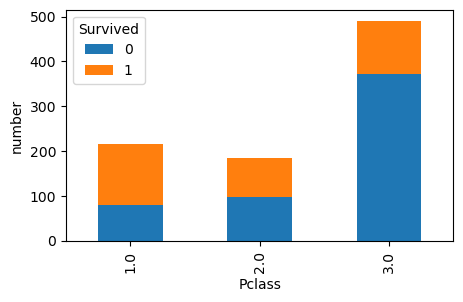

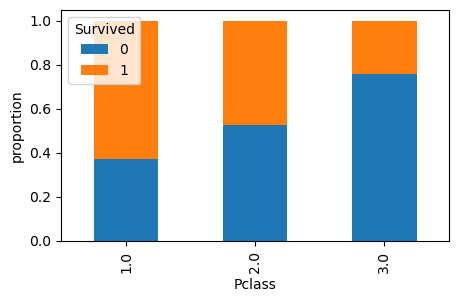

In [16]:
summary_pclass = df_c.groupby(['Pclass', 'Survived']).size().unstack()
p = summary_pclass.plot(kind='bar', stacked=True, figsize= (5,3));
p.set_ylabel('number');

prop_pclass =  summary_pclass.div(summary_pclass.sum(axis = 1), axis = 0)
p = prop_pclass.plot(kind='bar', stacked=True, figsize= (5,3));
p.set_ylabel('proportion');

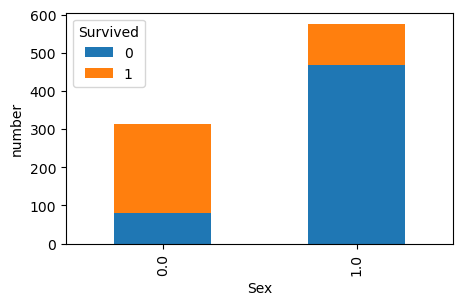

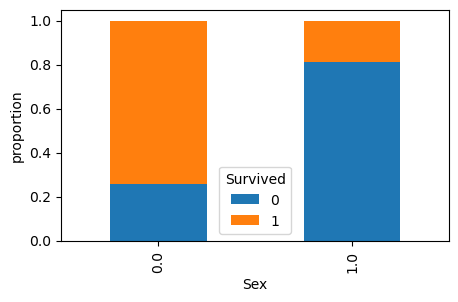

In [17]:
summary_sex = df_c.groupby(['Sex', 'Survived']).size().unstack()
p = summary_sex.plot(kind='bar', stacked=True, figsize=(5, 3)); # Recall: 1 for male, 0 for female
p.set_ylabel('number');

proportions_sex = summary_sex.div(summary_sex.sum(axis=1), axis=0)
p1 = proportions_sex.plot(kind='bar', stacked=True, figsize= (5,3));
p1.set_ylabel('proportion');

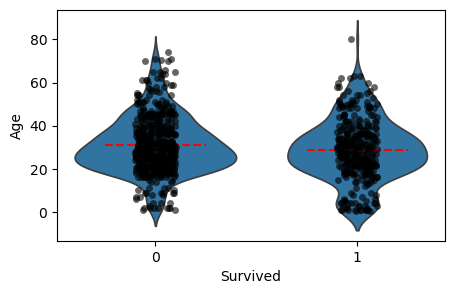

In [18]:
means = df_c.groupby('Survived')['Age'].mean()

plt.figure(figsize=(5, 3))
sns.violinplot(x='Survived', y='Age', data=df_c, inner=None)
sns.stripplot(x='Survived', y='Age', data=df_c, color='k', alpha=0.6)

for i, row in means.items():
    plt.hlines(row, xmin=i - 0.25, xmax=i + 0.25, color='red', linestyle='--')

plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

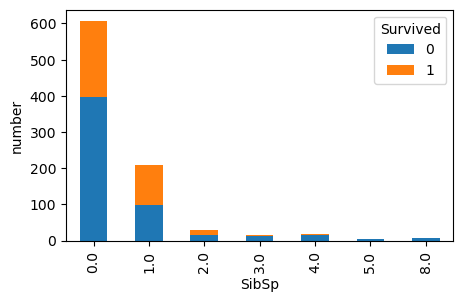

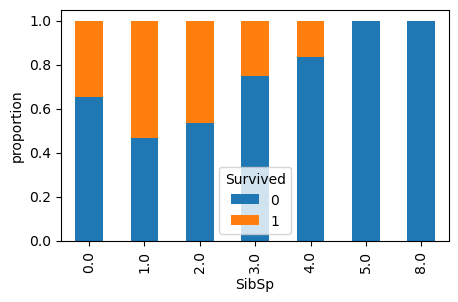

In [19]:
summary_SibSp = df_c.groupby(['SibSp', 'Survived']).size().unstack()
p = summary_SibSp.plot(kind='bar', stacked=True, figsize=(5, 3));
p.set_ylabel('number');


proportions_sibs = summary_SibSp.div(summary_SibSp.sum(axis=1), axis = 0)
p1 = proportions_sibs.plot(kind='bar', stacked=True, figsize=(5, 3));
p1.set_ylabel('proportion');

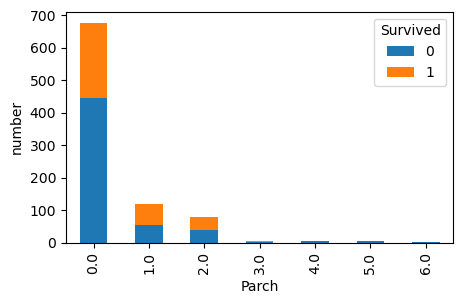

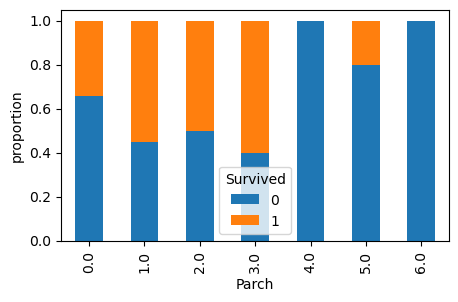

In [20]:
summary_Parch = df_c.groupby(['Parch', 'Survived']).size().unstack()
p = summary_Parch.plot(kind='bar', stacked=True, figsize=(5, 3));
p.set_ylabel('number');


proportions_parch = summary_Parch.div(summary_Parch.sum(axis=1), axis = 0)
p1 = proportions_parch.plot(kind='bar', stacked=True, figsize=(5, 3));
p1.set_ylabel('proportion');

# the proportion is not really meaningful for high parch number

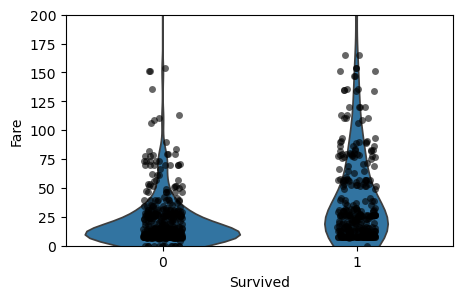

/tmp/ipykernel_24425/2084339451.py:11: RuntimeWarning: divide by zero encountered in log
  df_c['logFare'] = np.log(df_c['Fare'].values)


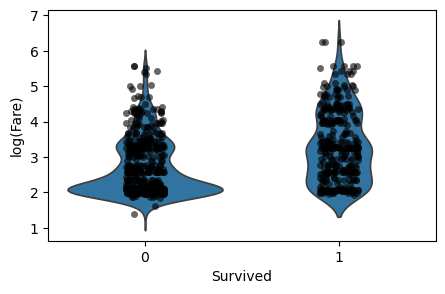

In [21]:
plt.figure(figsize=(5, 3))
sns.violinplot(x='Survived', y='Fare', data=df_c, inner=None)
sns.stripplot(x='Survived', y='Fare', data=df_c, color='k', alpha=0.6)
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.ylim([0, 200])
plt.show()



df_c['logFare'] = np.log(df_c['Fare'].values)
plt.figure(figsize=(5, 3))
sns.violinplot(x='Survived', y='logFare', data=df_c, inner=None)
sns.stripplot(x='Survived', y='logFare', data=df_c, color='k', alpha=0.6)
plt.xlabel('Survived')
plt.ylabel('log(Fare)')
plt.show()

# the thrend is more visible even if there are 15 cases in which the fare is zero (log 0 = -inf !)

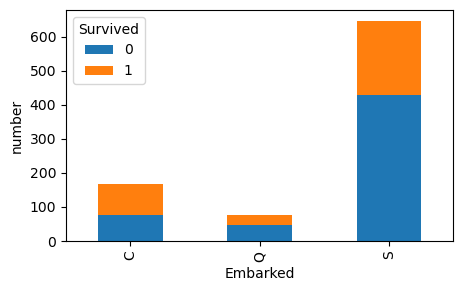

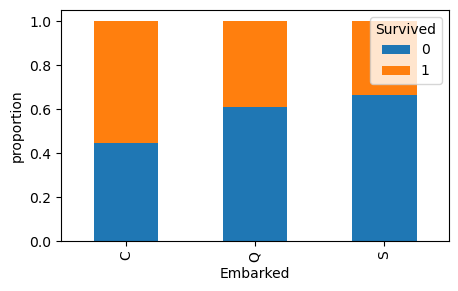

In [22]:
pd_port = pd.concat([X_embarked, y], axis = 1)

summary_Port = pd_port.groupby(['Embarked', 'Survived']).size().unstack()
p = summary_Port.plot(kind='bar', stacked=True, figsize=(5, 3));
p.set_ylabel('number');


proportions_parch = summary_Port.div(summary_Port.sum(axis=1), axis = 0)
p1 = proportions_parch.plot(kind='bar', stacked=True, figsize=(5, 3));
p1.set_ylabel('proportion');

## Summary from the data exploration

* Passenger class: there are 3 classes of passengers, 3rd class (the lowest) has much more 
passengers who didn't survived (around 350 vs around 200 for both 2nd and 1st class reunited). 
The number of third class passengers is more elevated (500 3rd class, vs 200 in 2nd class and 200
in first class). Nonetheless also, in proportion, the 3rd class passengers died much more than the first
class passengers: around 80 % of the third class passengers didn't survived vs 40% in the first class. 

* Sex is good predictor of survival. Around 80 % of men died whereas around 75% of women survived. 

* The age alone doesn't seem to be a good predictor of survival: the distributions of for the group of survivors
and of non survivors is pretty similar. 


* The number of parent/siblings and the age seem to be a weakly predicting factor: 65 % of both individuals
with parch = 0 or sibsp = 0 did not survived. 

* The fare is very spread, nonetheless, in log scale, we see a trend  


Conclusion: we already have a robot portrait of the person who died in the Titanic: single young poor men, having embarked at Southampton, probably workers.

Possibly correlated variables to study: Sibs and Parch, Fare and Pclass.



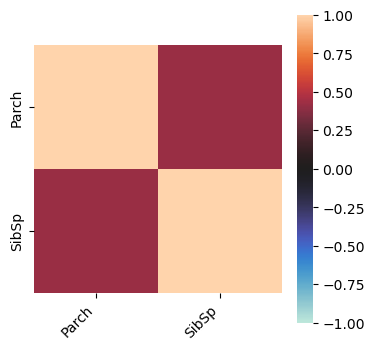

In [23]:
corr = df_c[['Parch', 'SibSp']].corr()
fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.show()

In [24]:
# 'Parch', 'SibSp' are highly correlated , thereforen we will fuse them in a single variable called FamMembers

X['FamMembers'] = X['Parch'] + X['SibSp']
X.drop('Parch', axis= 1, inplace= True)
X.drop('SibSp', axis= 1, inplace= True)

<Figure size 500x500 with 0 Axes>

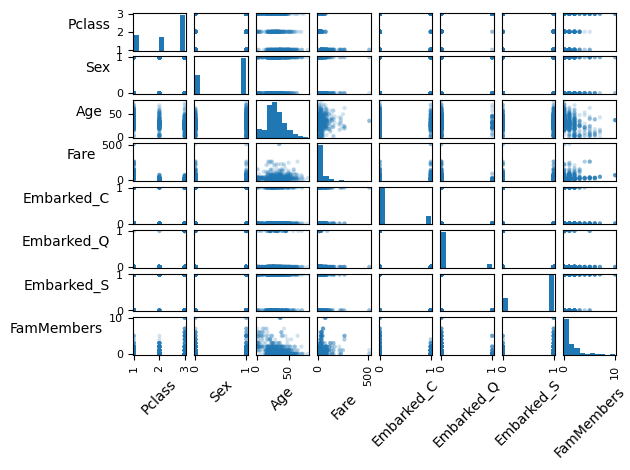

In [25]:
plt.figure(figsize=(5, 5));
axes = pd.plotting.scatter_matrix(X, alpha=0.2);
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45);
    ax.yaxis.label.set_rotation(0);
    ax.yaxis.label.set_ha('right');

plt.tight_layout();
plt.gcf().subplots_adjust(wspace=.15, hspace=.15);
plt.show();

# We don't see additional spurious correlations.

# Variable normalisation

In [ ]:
X['Age'] = X['Age']/100

Text(0, 0.5, 'Normalized age distribution')

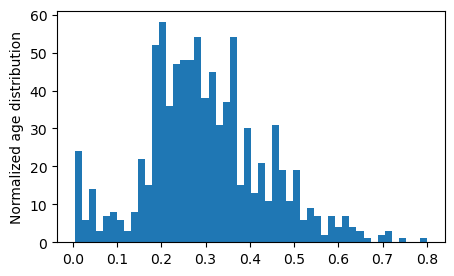

In [44]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(X['Age'].values, bins = 50);
ax.set_ylabel('Normalized age distribution')

In [45]:
X_fare = X['Fare'].copy()
scaler = PowerTransformer()

X_fare_norm = scaler.fit_transform(X_fare.values.reshape(-1, 1))

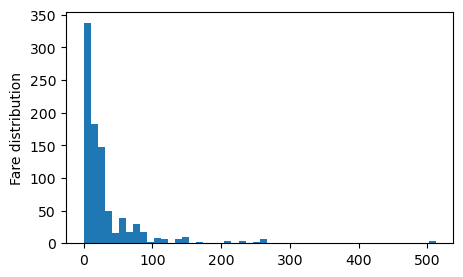

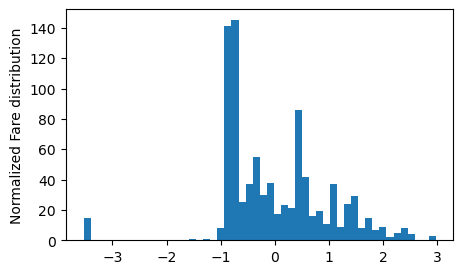

In [49]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(X['Fare'].values, bins = 50);
ax.set_ylabel('Fare distribution');

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(X_fare_norm, bins = 50);
ax.set_ylabel('Normalized Fare distribution');

In [51]:
X['Fare'] = X_fare_norm

# Baseline models:

In [87]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
y_pred = dummy_clf.predict(X)

print(f'Accuracy: {accuracy_score(y, y_pred)}')
print(f'Recall: {recall_score(y, y_pred)}')
print(f'Precision: {precision_score(y, y_pred)}')
print(f'F1-score: {f1_score(y, y_pred)}')

Accuracy: 0.6161616161616161
Recall: 0.0
Precision: 0.0
F1-score: 0.0


/home/jacques/Programmes/Anaconda3/envs/ML_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [98]:
# predict only 3rd class passengers
y_pred = X['Pclass'] != 3

print(f'Accuracy: {accuracy_score(y, y_pred)}')
print(f'Recall: {recall_score(y, y_pred)}')
print(f'Precision: {precision_score(y, y_pred)}')
print(f'F1-score: {f1_score(y, y_pred)}')

Accuracy: 0.6677890011223344
Recall: 0.652046783625731
Precision: 0.5575
F1-score: 0.601078167115903


In [99]:
# predict only women
y_pred = X['Sex'].values == 0

print(f'Accuracy: {accuracy_score(y, y_pred)}')
print(f'Recall: {recall_score(y, y_pred)}')
print(f'Precision: {precision_score(y, y_pred)}')
print(f'F1-score: {f1_score(y, y_pred)}')

Accuracy: 0.7867564534231201
Recall: 0.6812865497076024
Precision: 0.7420382165605095
F1-score: 0.7103658536585366


# Model training:

In [225]:
experiment_name = "Exp_2_XGB"
mlflow.set_experiment(experiment_name)

INFO: 'Exp_2_XGB' does not exist. Creating a new experiment


In [228]:
models = {'XGBClassifier': XGBClassifier(random_state=42),
          } # "Random Forest": RandomForestClassifier(), "Gradient Boosting": GradientBoostingClassifier(),

param_grid_rf = {
'n_estimators': [200, 250, 300],
'max_depth': [None, 40, 50, 60],
'min_samples_split': [3, 5, 7],
'min_samples_leaf': [2, 4, 8],
'max_features': ['auto', 'sqrt', 'log2'],
'bootstrap': [True, False]
}

param_grid_gbm = {
'n_estimators': [150, 200, 250],
'learning_rate': [0.1, 0.05, 0.01, 0.005],
'max_depth': [3, 5, 7],
'subsample': [0.8, 0.9, 1.0],
'min_samples_split': [3, 5, 7],
'min_samples_leaf': [1, 2, 3]
}


param_grid_xgb = {
    'n_estimators': [200, 500, 600],
    'learning_rate': [0.01, 0.07, 0.1, 0.3],
    'max_depth': [7, 13, 15],
    'grow_policy': ['depthwise', 'levelwise'],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'colsample_bylevel': [0.5, 0.7, 1.0],
    'colsample_bynode': [0.5, 0.7, 1.0],
    'importance_type': ['weight', 'gain', 'cover'],
    'booster':['gbtree'],
    'base_score': [0.5]
}


param_grids = {
"XGBClassifier": param_grid_xgb,
}


In [ ]:
with mlflow.start_run():       
    best_model = None
    best_score = 0
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5)
        grid_search.fit(X, y.values.ravel())
        score = grid_search.best_score_
        print(f"{model_name}: Best score = {score:.3f}")
        if score > best_score:
            best_model = grid_search.best_estimator_
            best_score = score
            
    mlflow.log_metric("acc", best_score)
        
    for key, value in best_model.get_params().items():
        serialized_model = joblib.dump(value, f"{experiment_name}.pkl")
        mlflow.log_param(key, value)    

In [221]:
best_model

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300)

In [191]:
best_score

0.83841566756638

# Submit prediction

In [192]:
X_test = pd.read_csv('../data/test.csv')

In [193]:
pass_ID = X_test[['PassengerId']]

In [194]:
X_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [195]:
## Apply the same preprocessings:

X_test.drop('Cabin', inplace=True, axis=1)
X_test.drop('PassengerId', inplace=True, axis=1)
X_test.drop('Name', inplace=True, axis=1)
X_test.drop('Ticket', inplace=True, axis=1)

label         = le.transform(X_test['Sex'])
X_test["Sex"] = label 


X_test['Age']  = X_test['Age']/100
X_test['Fare'] = scaler.transform(X_test[['Fare']].values.reshape(-1, 1))
 
df_onehot = pd.get_dummies(X_test[["Embarked"]], columns=['Embarked'], dtype='int64')
df_concat = pd.concat([X_test, df_onehot], axis=1)
X_test = df_concat.drop(columns=['Embarked'])

X_test = pd.DataFrame(data = imputer.transform(X_test), columns=X_test.columns)

X_test['FamMembers'] = X_test['Parch'] + X_test['SibSp']
X_test.drop('Parch', axis=1, inplace= True)
X_test.drop('SibSp', axis=1, inplace= True)

In [196]:
X_test

,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,FamMembers
0,3.0,1.0,0.345,-0.802204,0.0,1.0,0.0,0.0
1,3.0,0.0,0.470,-0.913735,0.0,0.0,1.0,1.0
2,2.0,1.0,0.620,-0.589230,0.0,1.0,0.0,0.0
3,3.0,1.0,0.270,-0.701150,0.0,0.0,1.0,0.0
4,3.0,0.0,0.220,-0.351245,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...
413,3.0,1.0,33.600,-0.774439,0.0,0.0,1.0,0.0
414,1.0,0.0,0.390,1.712794,1.0,0.0,0.0,0.0
415,3.0,1.0,0.385,-0.878820,0.0,0.0,1.0,0.0
416,3.0,1.0,33.600,-0.774439,0.0,0.0,1.0,0.0


In [197]:
y_test = best_model.predict(X_test)

In [198]:
df_pred = pd.concat([pass_ID, pd.DataFrame(data=y_test, columns=['Survived'])], axis= 1)

In [199]:
df_pred.to_csv('Kaggle_2.csv', index = False)